In [67]:
import os.path as osp
import os
from pylgmath import se3op
import matplotlib.pyplot as plt
from bisect import bisect_left
from estimate_qc import *

In [3]:
root = '/workspace/raid/krb/boreas/boreas-2021-09-02-11-42/'
debug_path = '/home/krb/ASRL/temp/steam_icp/boreas_velodyne/steamlio/boreas-2021-09-02-11-42_debug.txt'

In [104]:
def get_applanix_data_at_time(time, gps_times, gps_lines):

    idx = bisect_left(gps_times, time)
    if idx >= len(gps_times):
        idx = len(gps_times) - 1
    d = abs(gps_times[idx] - time)
    if gps_times[idx] < time and idx < len(gps_times) - 1:
        if abs(gps_times[idx + 1] - time) < d:
            idx += 1
    elif gps_times[idx] > time and idx > 0:
        if abs(gps_times[idx - 1] - time) < d:
            idx -= 1

    closest = idx

    def _parse(gps_line):
        return [float(x) for x in gps_line.split(',')]

    gt_time = gps_times[closest]

    def _interpolate(lower, upper, t):
        assert(len(lower) == len(upper))
        tlow = lower[0]
        tupp = upper[0]
        assert(tlow < t and t < tupp)
        delta = tupp - tlow
        if delta == 0:
            return lower
        ratio = (t - tlow) / delta
        out = []
        for low, upp in zip(lower, upper):
            out.append(low + (upp - low) * ratio)
        out[0] = t
        return out

    line = _parse(gps_lines[closest])
    if gt_time < time:
        if closest == len(gps_lines) - 1:
            return line
        line_lower = line
        line_upper = _parse(gps_lines[closest + 1])
        return _interpolate(line_lower, line_upper, time)
    elif gt_time > time:
        if closest == 0:
            return line
        line_lower = _parse(gps_lines[closest - 1])
        line_upper = line
        return _interpolate(line_lower, line_upper, time)
    elif gt_time == time:
        return line

# Adjust orientation and translation from T_enu_applanix --> T_enu_sensor
def adjust_pose_to_sensor(line, T_applanix_sensor):
    T_enu_applanix = np.identity(4, dtype=np.float64)
    T_enu_applanix[0:3, 0:3] = yawPitchRollToRot(line[9], line[8], line[7])  # we read C_enu_applanix
    T_enu_applanix[0, 3] = line[1]
    T_enu_applanix[1, 3] = line[2]
    T_enu_applanix[2, 3] = line[3]
    T_enu_sensor = np.matmul(T_enu_applanix, T_applanix_sensor)
    line[1] = T_enu_sensor[0, 3]
    line[2] = T_enu_sensor[1, 3]
    line[3] = T_enu_sensor[2, 3]
    y, p, r = rotToYawPitchRoll(T_enu_sensor[:3, :3])  # we write y, p, r of C_enu_sensor
    line[7] = r
    line[8] = p
    line[9] = y

    adT_sensor_applanix = Transformation(T_ba=T_applanix_sensor).inverse().adjoint()
    varpi_applanix = np.zeros(6, dtype=np.float64)
    vbar = np.array([line[4], line[5], line[6]], dtype=np.float64)  # in enu
    varpi_applanix[:3] = np.matmul(T_enu_applanix[:3, :3].T, vbar.reshape(3, 1)).squeeze()  # rotate from enu to applanix
    varpi_applanix[3:] = np.array([line[12], line[11], line[10]], dtype=np.float64)     # angular already in applanix
    varpi_sensor = np.matmul(adT_sensor_applanix, varpi_applanix.reshape(6, 1)).squeeze()
    line[4], line[5], line[6] = np.matmul(T_enu_sensor[:3, :3], varpi_sensor[:3].reshape(3, 1)).squeeze()   # rotate back to enu
    line[12], line[11], line[10] = varpi_sensor[3:]     # angular should already be in sensor frame
    return line

def rotToYawPitchRoll(C, eps = 1e-15):
    i = 2
    j = 1
    k = 0
    c_y = np.sqrt(C[i, i]**2 + C[j, i]**2)
    if c_y > eps:
        r = np.arctan2(C[j, i], C[i, i])
        p = np.arctan2(-C[k, i], c_y)
        y = np.arctan2(C[k, j], C[k, k])
    else:
        r = 0
        p = np.arctan2(-C[k, i], c_y)
        y = np.arctan2(-C[j, k], C[j, j])

    return y, p, r

In [65]:
gps_file = osp.join(root, 'applanix', 'gps_post_process.csv')
with open(gps_file, 'r') as gf:
    header = gf.readline()
    gps_lines = gf.readlines()
    gps_times = []
    for line in gps_lines:
        gps_times.append(float(line.split(',')[0]))

In [117]:
lpath = osp.join(root, 'lidar')
lidar_files = []
if osp.exists(lpath):
    lidar_files = sorted([f for f in os.listdir(lpath) if f.endswith('.bin')])

T_applanix_lidar = np.loadtxt(osp.join(root, 'calib', 'T_applanix_lidar.txt'), dtype=np.float64)
T_yfwd2xfwd = np.array([0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]).reshape(4, 4)
imu_body_raw_to_applanix = np.array([0, -1, 0, -1, 0, 0, 0, 0, -1]).reshape(3, 3)
AdT_al = se3op.tranAd(T_applanix_lidar)
T_robot_lidar = T_yfwd2xfwd @ T_applanix_lidar
T_lidar_robot = get_inverse_tf(T_robot_lidar)
T_applanix_robot = T_applanix_lidar @ T_lidar_robot
AdT_rl = se3op.tranAd(T_robot_lidar)

lidar_gt = []
times_gt = []
with open(osp.join(root, 'applanix', 'lidar_poses.csv')) as f:
    h = f.readline()
    for line in f.readlines():
        parts = line.rstrip().split(',')
        lidar_gt.append([float(x) for x in parts])
        times_gt.append(int(parts[0]))
lidar_gt = np.array(lidar_gt)

poses_gt = []
vels_gt = []
# TODO: get T_k_0 in robot frame...
for i in range(lidar_gt.shape[0]):
    T_enu_lidar = np.eye(4)
    T_enu_lidar[:3, :3] = yawPitchRollToRot(lidar_gt[i, 9], lidar_gt[i, 8], lidar_gt[i, 7])
    T_enu_lidar[0, 3] = lidar_gt[i, 1]
    T_enu_lidar[1, 3] = lidar_gt[i, 2]
    T_enu_lidar[2, 3] = lidar_gt[i, 3]
    T_enu_robot = T_enu_lidar @ T_lidar_robot
    poses_gt.append(get_inverse_tf(T_enu_robot))
    w_lidar = np.zeros(6)
    w_lidar[-3:] = np.array([lidar_gt[i, 12], lidar_gt[i, 11], lidar_gt[i, 10]])
    w_lidar[:3] = (T_enu_lidar[:3, :3].T @ np.array([lidar_gt[i, 4], lidar_gt[i, 5], lidar_gt[i, 6]]).reshape(3, 1)).squeeze()
    vels_gt.append(AdT_rl @ w_lidar)
    # TODO: vels_gt, accels_gt

poses_gt = np.array(poses_gt)
T_enu_robot_0 = get_inverse_tf(poses_gt[0])
rpys_gt = []
for i in range(lidar_gt.shape[0]):
    poses_gt[i] = get_inverse_tf(poses_gt[i] @ T_enu_robot_0)
    rpys_gt.append(rotToYawPitchRoll(poses_gt[i])[::-1])

rpys_gt = np.array(rpys_gt)
vels_gt = np.array(vels_gt)
accels_gt = np.array(accels_gt)
times_gt = np.array(times_gt) * 1.0e-6

## Acceleration Ground Truth

In [76]:
accels_gt = []
for tgt in times_gt:
    gps_data = get_applanix_data_at_time(tgt, gps_times, gps_lines)
    accels_gt.append((T_yfwd2xfwd[:3, :3] @ np.array([gps_data[15], gps_data[14], gps_data[13]]).reshape(3, 1)).squeeze())
accels_gt = np.array(accels_gt)

## Raw IMU Measurements

In [ ]:
with open(osp.join(root, 'applanix', 'imu_raw.csv'), 'r') as f:
    h = f.readline()
    imu_raw_lines = f.readlines()

imu_data = []
imu_times = []
accel_minus_gravity = []
g = np.array([0, 0, -9.8042]).reshape(3, 1)
for line in imu_raw_lines:
    line = [float(x) for x in line.rstrip().split(',')]
    imu_times.append(line[0])
    w_raw = T_yfwd2xfwd[:3, :3] @ imu_body_raw_to_applanix @ np.array([line[3], line[2], line[1]]).reshape(3, 1)
    a_raw = T_yfwd2xfwd[:3, :3] @ imu_body_raw_to_applanix @ np.array([line[6], line[5], line[4]]).reshape(3, 1)
    imu_data.append(np.vstack((a_raw, w_raw)).squeeze())
    gps_data = get_applanix_data_at_time(line[0], gps_times, gps_lines)

    T_enu_applanix = np.eye(4)
    T_enu_applanix[:3, :3] = yawPitchRollToRot(gps_data[9], gps_data[8], gps_data[7])
    T_enu_applanix[0, 3] = gps_data[1]
    T_enu_applanix[1, 3] = gps_data[2]
    T_enu_applanix[2, 3] = gps_data[3]
    T_enu_robot = T_enu_applanix @ T_applanix_robot
    accel_minus_gravity.append(a_raw + T_enu_robot[:3, :3].T @ g)

with open(osp.join(root, 'applanix', 'accel_raw_minus_gravity.csv'), 'w') as f:
    f.write('GPSTime,accelx,accely,accelz\n')
    for imu_ts, amg in zip(imu_times, accel_minus_gravity):
        f.write('{},{},{},{}\n'.format(imu_ts, amg[0, 0], amg[1, 0], amg[2, 0]))

imu_data = np.array(imu_data)
imu_times = np.array(imu_times)
accel_minus_gravity = np.array(accel_minus_gravity)

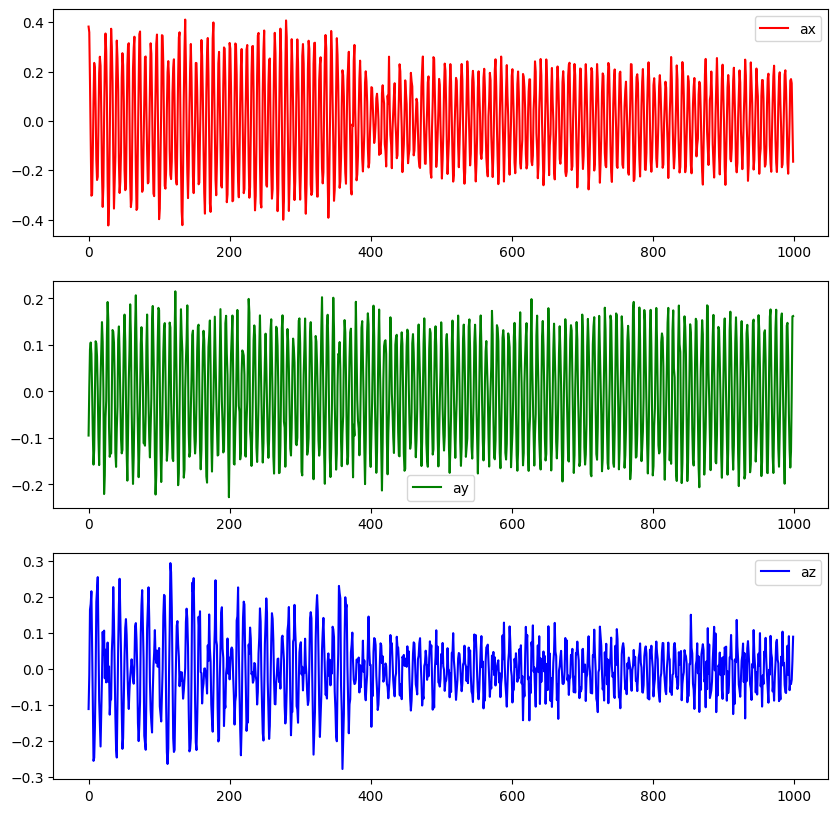

In [504]:
N = 1000
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(accel_minus_gravity[:N, 0], 'r', label='ax')
axs[1].plot(accel_minus_gravity[:N, 1], 'g', label='ay')
axs[2].plot(accel_minus_gravity[:N, 2], 'b', label='az')
# mean_a = []
# for j in range(20, N):
#     mean_a.append(np.mean(accel_minus_gravity[j - 20 : j, 0]))
# axs[0].plot(mean_a, 'b', label='mean_a')
    
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

In [ ]:
# for line in imu_raw_lines:
#     line = [float(x) for x in line.rstrip().split(',')]
#     imu_times.append(line[0])
#     w_raw = T_yfwd2xfwd[:3, :3] @ imu_body_raw_to_applanix @ np.array([line[3], line[2], line[1]]).reshape(3, 1)
#     a_raw = T_yfwd2xfwd[:3, :3] @ imu_body_raw_to_applanix @ np.array([line[6], line[5], line[4]]).reshape(3, 1)
#     imu_data.append(np.vstack((a_raw, w_raw)).squeeze())
#     gps_data = get_applanix_data_at_time(line[0], gps_times, gps_lines)

#     T_enu_applanix = np.eye(4)
#     T_enu_applanix[:3, :3] = yawPitchRollToRot(gps_data[9], gps_data[8], gps_data[7])
#     T_enu_applanix[0, 3] = gps_data[1]
#     T_enu_applanix[1, 3] = gps_data[2]
#     T_enu_applanix[2, 3] = gps_data[3]
#     T_enu_robot = T_enu_applanix @ T_applanix_robot
#     accel_minus_gravity.append(a_raw + T_enu_robot[:3, :3].T @ g)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accel:
std: [0.19473512 0.11221442 0.09217995]
cov: [0.03792177 0.01259208 0.00849714]
ang vel:
std: [0.00234283 0.00488661 0.00182886]
cov: [5.48885234e-06 2.38789649e-05 3.34471102e-06]


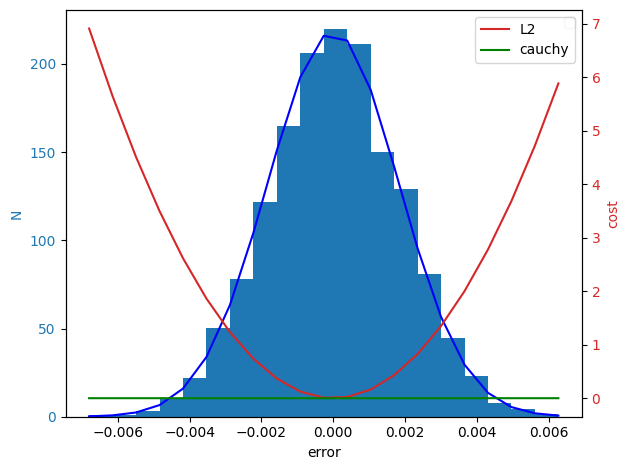

In [495]:
print('accel:')
# print(np.std(accel_minus_gravity[:1000].squeeze()**2, axis=0))
acc_cov = np.mean((accel_minus_gravity[:4000]**2).squeeze(), axis=0)
acc_std = np.sqrt(acc_cov)
print('std: {}'.format(acc_std))
print('cov: {}'.format(acc_cov))
# print(np.sqrt(np.mean((accel_minus_gravity[:1000]**2).squeeze()**2, axis=0)))
print('ang vel:')
ang_cov = np.mean((imu_data[:4000, 3:]**2).squeeze(), axis=0)
# ang_cov = np.array([0.04898588, 0.06860401, 0.04319808])
ang_std = np.sqrt(ang_cov)
print('std: {}'.format(ang_std))
print('cov: {}'.format(ang_cov))

def gaussian(x, mu=0, sigma=1.0):
    return (1 / (sigma * np.sqrt( 2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('error')
ax1.set_ylabel('N', color=color)
dim = 5
N = 20
_, bins, _ = ax1.hist(imu_data[:4000, dim], bins=20, density=True)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(bins, gaussian(bins, mu=0, sigma=ang_std[dim - 3]), color='b')
# ax1.vlines(ang_std[dim - 3], ymin=0, ymax=2, colors='r', label='1-sigma')
ax1.legend()

bins = np.array(bins)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('cost', color=color)
e = np.sqrt(bins**2 / ang_cov[dim - 3])
L2 = 0.5 * (e**2)
ax2.plot(bins, L2, color=color, label='L2')
k = 0.015
cauchy = (k**2 / 2) * np.log(1 + (e / k)**2)
ax2.plot(bins, cauchy, color='g', label='cauchy')

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

fig.tight_layout()
# _, bins, _ = plt.hist(accel_minus_gravity[:1000, 0], bins=20)

# plt.plot(bins, L2, 'r')
# plt.
# plt.hist(imu_data[:1000, 1], bins=20)
plt.show()

In [ ]:
print 

In [324]:
print(bins)

[-0.42408758 -0.38235634 -0.34062511 -0.29889388 -0.25716265 -0.21543141
 -0.17370018 -0.13196895 -0.09023772 -0.04850648 -0.00677525  0.03495598
  0.07668721  0.11841845  0.16014968  0.20188091  0.24361214  0.28534338
  0.32707461  0.36880584  0.41053707]


## Estimated States
data: T(4,4), w(6), dw(6), b(6), cov(18,18)

In [447]:
data = []
with open(debug_path) as f:
    for line in f.readlines():
        data.append([float(x) for x in line.rstrip().split()])
# data = data[:len(data) // 2]
data = np.array(data)
poses = []  # T_ms
vels = []  # w_rm_ins
accels = []  # dw_rm_ins
biases = []  # bias on accel meas in robot frame
covs = []  # cov on pos, w, dw
T_mis = []
rpys = []
for i in range(data.shape[0]):
    T = data[i, :16].reshape(4, 4) @ T_lidar_robot
    poses.append(T)
    vels.append(-1 * data[i, 16:22])
    accels.append(-1 * data[i, 22:28])
    biases.append(data[i, 28: 34])
    covs.append(data[i, 34:34+18*18].reshape(18, 18))
    T_mis.append(data[i, -16:].reshape(4, 4))
    rpys.append(rotToYawPitchRoll(T[:3, :3])[::-1])

poses = np.array(poses)
vels = np.array(vels)
accels = np.array(accels)
covs = np.array(covs)
biases = np.array(biases)
rpys = np.array(rpys)
T_mis = np.array(T_mis)

## Visualize Debug States

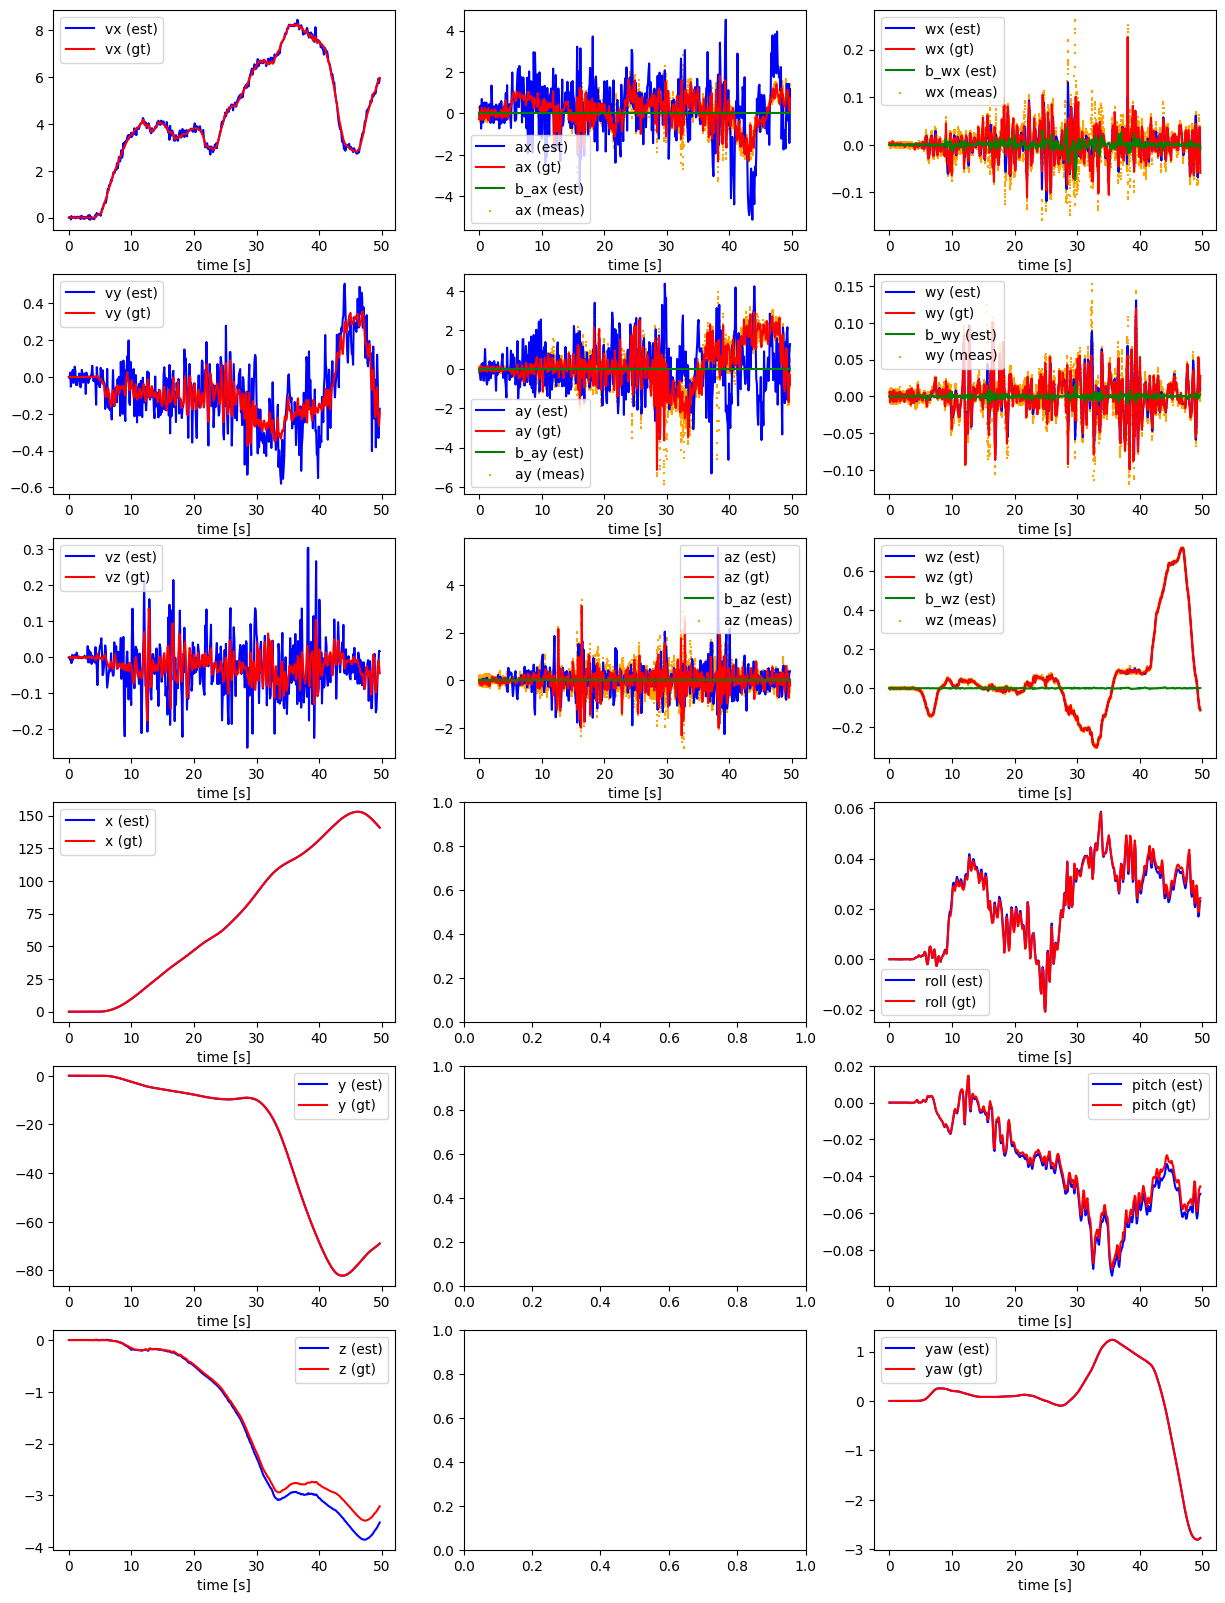

In [448]:
N = poses.shape[0]
times = np.copy(times_gt[:N])
t0 = times[0]
tN = times[-1]
imu_plot = []
imu_plot_times = []
accel_minus_plot = []
for i in range(imu_data.shape[0]):
    if t0 <= imu_times[i] <= tN:
        imu_plot.append(imu_data[i, :])
        imu_plot_times.append(imu_times[i])
        accel_minus_plot.append(accel_minus_gravity[i, :])
imu_plot = np.array(imu_plot)
imu_plot_times = np.array(imu_plot_times)
accel_minus_plot = np.array(accel_minus_plot)
imu_plot_times -= t0
times -= t0
fig, axs = plt.subplots(6, 3, figsize=(15, 20))

# bodyframe linear velocity
axs[0, 0].plot(times, vels[:, 0], 'b', label='vx (est)')
axs[0, 0].plot(times, vels_gt[:N, 0], 'r', label='vx (gt)')
axs[0, 0].set_xlabel('time [s]')
axs[0, 0].legend()
axs[1, 0].plot(times, vels[:, 1], 'b', label='vy (est)')
axs[1, 0].plot(times, vels_gt[:N, 1], 'r', label='vy (gt)')
axs[1, 0].set_xlabel('time [s]')
axs[1, 0].legend()
axs[2, 0].plot(times, vels[:, 2], 'b', label='vz (est)')
axs[2, 0].plot(times, vels_gt[:N, 2], 'r', label='vz (gt)')
axs[2, 0].set_xlabel('time [s]')
axs[2, 0].legend()

# body frame linear acceleration
axs[0, 1].plot(times, accels[:, 0], 'b', label='ax (est)')
axs[0, 1].plot(times, accels_gt[:N, 0], 'r', label='ax (gt)')
axs[0, 1].plot(times, biases[:, 0], 'g', label='b_ax (est)')
axs[0, 1].scatter(imu_plot_times, accel_minus_plot[:, 0], marker='+', color='orange', s=2, label='ax (meas)')
axs[0, 1].set_xlabel('time [s]')
axs[0, 1].legend()
axs[1, 1].plot(times, accels[:, 1], 'b', label='ay (est)')
axs[1, 1].plot(times, accels_gt[:N, 1], 'r', label='ay (gt)')
axs[1, 1].plot(times, biases[:, 1], 'g', label='b_ay (est)')
axs[1, 1].scatter(imu_plot_times, accel_minus_plot[:, 1], marker='+', color='orange', s=2, label='ay (meas)')
axs[1, 1].set_xlabel('time [s]')
axs[1, 1].legend()
axs[2, 1].plot(times, accels[:, 2], 'b', label='az (est)')
axs[2, 1].plot(times, accels_gt[:N, 2], 'r', label='az (gt)')
axs[2, 1].plot(times, biases[:, 2], 'g', label='b_az (est)')
axs[2, 1].scatter(imu_plot_times, accel_minus_plot[:, 2], marker='+', color='orange', s=2, label='az (meas)')
axs[2, 1].set_xlabel('time [s]')
axs[2, 1].legend()

# body frame angular velocity
axs[0, 2].plot(times, vels[:, 3], 'b', label='wx (est)')
axs[0, 2].plot(times, vels_gt[:N, 3], 'r', label='wx (gt)')
axs[0, 2].plot(times, biases[:, 3], 'g', label='b_wx (est)')
axs[0, 2].scatter(imu_plot_times, imu_plot[:, 3], marker='+', color='orange', s=2, label='wx (meas)')
axs[0, 2].set_xlabel('time [s]')
axs[0, 2].legend()
axs[1, 2].plot(times, vels[:, 4], 'b', label='wy (est)')
axs[1, 2].plot(times, vels_gt[:N, 4], 'r', label='wy (gt)')
axs[1, 2].plot(times, biases[:, 4], 'g', label='b_wy (est)')
axs[1, 2].scatter(imu_plot_times, imu_plot[:, 4], marker='+', color='orange', s=2, label='wy (meas)')
axs[1, 2].set_xlabel('time [s]')
axs[1, 2].legend()
axs[2, 2].plot(times, vels[:, 5], 'b', label='wz (est)')
axs[2, 2].plot(times, vels_gt[:N, 5], 'r', label='wz (gt)')
axs[2, 2].plot(times, biases[:, 5], 'g', label='b_wz (est)')
axs[2, 2].scatter(imu_plot_times, imu_plot[:, 5], marker='+', color='orange', s=2, label='wz (meas)')
axs[2, 2].set_xlabel('time [s]')
axs[2, 2].legend()

# position relative to the map frame
axs[3, 0].plot(times, poses[:, 0, 3], 'b', label='x (est)')
axs[3, 0].plot(times, poses_gt[:N, 0, 3], 'r', label='x (gt)')
axs[3, 0].set_xlabel('time [s]')
axs[3, 0].legend()
axs[4, 0].plot(times, poses[:, 1, 3], 'b', label='y (est)')
axs[4, 0].plot(times, poses_gt[:N, 1, 3], 'r', label='y (gt)')
axs[4, 0].set_xlabel('time [s]')
axs[4, 0].legend()
axs[5, 0].plot(times, poses[:, 2, 3], 'b', label='z (est)')
axs[5, 0].plot(times, poses_gt[:N, 2, 3], 'r', label='z (gt)')
axs[5, 0].set_xlabel('time [s]')
axs[5, 0].legend()

# orientation relative to the map frame
axs[3, 2].plot(times, rpys[:, 0], 'b', label='roll (est)')
axs[3, 2].plot(times, rpys_gt[:N, 0], 'r', label='roll (gt)')
axs[3, 2].set_xlabel('time [s]')
axs[3, 2].legend()
axs[4, 2].plot(times, rpys[:, 1], 'b', label='pitch (est)')
axs[4, 2].plot(times, rpys_gt[:N, 1], 'r', label='pitch (gt)')
axs[4, 2].set_xlabel('time [s]')
axs[4, 2].legend()
axs[5, 2].plot(times, rpys[:, 2], 'b', label='yaw (est)')
axs[5, 2].plot(times, rpys_gt[:N, 2], 'r', label='yaw (gt)')
axs[5, 2].set_xlabel('time [s]')
axs[5, 2].legend()

plt.show()

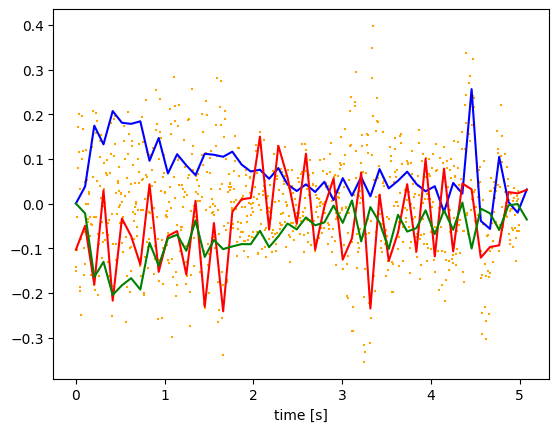

In [287]:
plt.plot(times[:50], accels[:50, 2], 'b', label='ay (est)')
plt.plot(times[:50], accels_gt[:50, 2], 'r', label='ay (gt)')
plt.plot(times[:50], biases[:50, 2], 'g', label='b_ay (est)')
plt.scatter(imu_plot_times[:1000], accel_minus_plot[:1000, 2], marker='+', color='orange', s=2, label='ay (meas)')
plt.xlabel('time [s]')
plt.show()

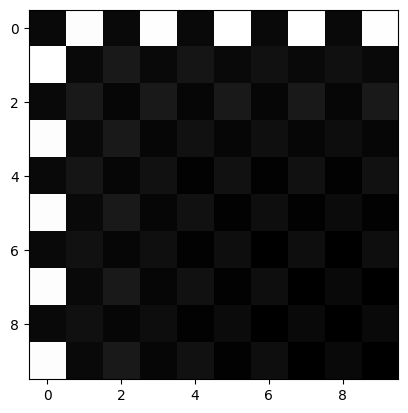

In [473]:
dim = 2 
N = 5
Ainv = np.eye(dim * N)
dt = 0.1
Ak = np.array([[1, dt],[0, 1]])

for i in range(1, N):
    Ainv[i * dim : (i + 1) * dim, (i - 1) * dim : i * dim] = -Ak

Qinv = np.eye(10) * 0.1

P_check_inv = Ainv.T @ Qinv @ Ainv
P_check = npla.inv(P_check_inv)

L = npla.cholesky(P_check_inv)
V = npla.cholesky(P_check)
V2 = npla.inv(L).T
plt.imshow(np.log(np.abs(P_check)), 'binary')
plt.show()